##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CNNs for Heart Rate Estimation and Human Activity Recognition in Wrist Worn Sensing Applications - HAR Transfer Learning

This is code for reproducing the HAR shown in the paper presented at the WristSense workshop as part of PerCom 2020.


The data was collected by D. Jarchi and A. Casson (2017) and downloaded from PhysioNet.
The data was prepared for this script using the `HAR_Data.ipynb` Notebook.


### Designed to be run using Google Colaboratory

If you wish to run locally, comment out the first two lines in the following cell and set your new directory in `os.chdir()`.

You will also have to manage pip installs that feature in some cells throughout this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pylab as plt
import numpy as np
import PIL.Image as Image


try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf

# Change cwd if necessary
path = '/content/drive/My Drive/WristSense/CNNs_HAR_and_HR/Data/'
os.chdir(path)

In [0]:
!pip install -U tf-hub-nightly
!pip install tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

## Prep the Data

In order to train, validate and test a model the dataset has to be split into three seperate train/val/test folders.

The data files used for this Notebook are:
- `PPG_256Hz`
- `PPG_256Hz_Split/train`
- `PPG_256Hz_Split/val`
- `PPG_256Hz_Split/test`

Train-test-val split:

In [4]:
!pip install split-folders tqdm
import split_folders

data_root = "PPG_256Hz"
output_fldr = "PPG_256Hz_Split"

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio(data_root, output=output_fldr, seed=1337, ratio=(.8, .1, .1)) # default values

Copying files: 6038 files [43:52,  2.28 files/s]


In [0]:
train_dir = './'+str(output_fldr)+'/train'
val_dir   = './'+str(output_fldr)+'/val'
test_dir  = './'+str(output_fldr)+'/test'

## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer. Any [TensorFlow 2 compatible image classifier URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/inception_v3/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (299, 299)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Load the ImageNet labels predictions

Fetch the `ImageNet` labels

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


## Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Load the data into generators

The simplest way to load the data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [9]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255) 

train_generator = image_generator.flow_from_directory(
    str(train_dir),
    target_size=IMAGE_SHAPE) # set as training data

validation_generator = image_generator.flow_from_directory(
    str(val_dir),
    target_size=IMAGE_SHAPE) # set as validation data

test_generator = image_generator.flow_from_directory(
    str(test_dir), # test data
    target_size=IMAGE_SHAPE,
    shuffle = False) # set as test data

Found 4829 images belonging to 4 classes.
Found 602 images belonging to 4 classes.
Found 607 images belonging to 4 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [10]:
for train_image_batch, train_label_batch in train_generator:
  print("Train Image batch shape: ", train_image_batch.shape)
  print("Train Label batch shape: ", train_label_batch.shape)
  break

for val_image_batch, val_label_batch in validation_generator:
  print("Val Image batch shape: ", val_image_batch.shape)
  print("Val Label batch shape: ", val_label_batch.shape)
  break

for test_image_batch, test_label_batch in test_generator:
  print("Test Image batch shape: ", test_image_batch.shape)
  print("Test Label batch shape: ", test_label_batch.shape)
  break

Train Image batch shape:  (32, 299, 299, 3)
Train Label batch shape:  (32, 4)
Val Image batch shape:  (32, 299, 299, 3)
Val Label batch shape:  (32, 4)
Test Image batch shape:  (32, 299, 299, 3)
Test Label batch shape:  (32, 4)


### Run the classifier on a batch of images

Now run the classifier on the training image batch.

In [11]:
result_batch = classifier.predict(test_image_batch)
result_batch.shape

(32, 1001)

In [12]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['envelope', 'oscilloscope', 'envelope', 'envelope', 'envelope',
       'envelope', 'envelope', 'envelope', 'envelope', 'envelope',
       'envelope', 'envelope', 'envelope', 'envelope', 'envelope',
       'envelope', 'envelope', 'paper towel', 'envelope', 'envelope',
       'envelope', 'envelope', 'envelope', 'envelope', 'envelope',
       'envelope', 'envelope', 'envelope', 'envelope', 'envelope',
       'envelope', 'envelope'], dtype='<U30')

Now check how these pre-trained ImageNet predictions line up with the images:

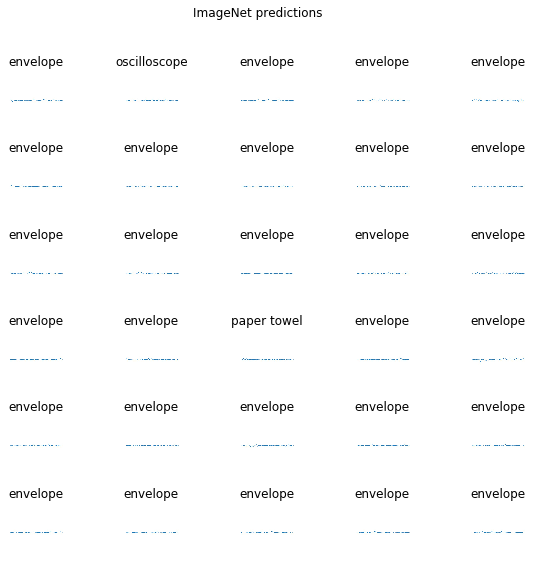

In [13]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(test_image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are no good, but understandable considering that these are not the classes the model was trained for.

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2" #@param {type:"string"}

Create the feature extractor.

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(299,299,3))

It returns a 2048-length vector for each image:

In [16]:
feature_batch = feature_extractor_layer(train_image_batch)
print(feature_batch.shape)

(32, 2048)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [0]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [18]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(train_generator.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
predictions = model(train_image_batch)

In [20]:
predictions.shape

TensorShape([32, 4])

### Train the model

Use compile to configure the training process:

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 20 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [23]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = 24,
    callbacks = [batch_stats_callback])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 151.0 steps, validate for 18 steps
Epoch 1/24
151/151 [==============================] - 28s 187ms/step - loss: 0.5704 - acc: 0.7812 - val_loss: 0.4167 - val_acc: 0.8212
Epoch 2/24
151/151 [==============================] - 22s 147ms/step - loss: 0.3836 - acc: 0.8438 - val_loss: 0.3652 - val_acc: 0.8247
Epoch 3/24
151/151 [==============================] - 22s 145ms/step - loss: 0.3218 - acc: 0.8750 - val_loss: 0.3325 - val_acc: 0.8403
Epoch 4/24
151/151 [==============================] - 22s 145ms/step - loss: 0.2976 - acc: 0.9375 - val_loss: 0.2970 - val_acc: 0.8681
Epoch 5/24
151/151 [==============================] - 22s 145ms/step - loss: 0.2776 - acc: 0.8750 - val_loss: 0.3076 - val_acc: 0.8472
Epoch 6/24
151/151 [==============================] - 22s 146ms/step - loss: 0.2568 - acc: 0.8125 - val_loss: 0.2884 - val_acc: 0.8681
Epoch 7/24
151/151 [==============================] - 22s 148ms/step - loss: 0.2429 - acc: 0.9688 - val_loss: 0.2512 - val_acc: 0.8924
Epoch 8/24

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

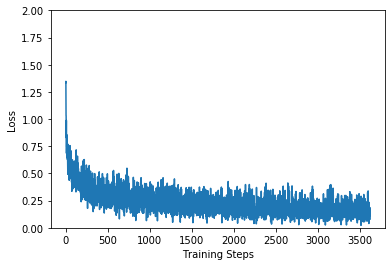

In [24]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

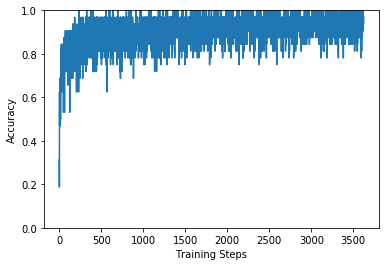

In [25]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions - for a batch

To redo the plot from before, first get the ordered list of class names:

In [26]:
class_names = sorted(test_generator.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['High', 'Low', 'Run', 'Walk'], dtype='<U4')

Run the test image batch through the model and convert the indices to class names.

In [0]:
predicted_batch = model.predict(test_image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [0]:
label_id = np.argmax(test_label_batch, axis=-1)

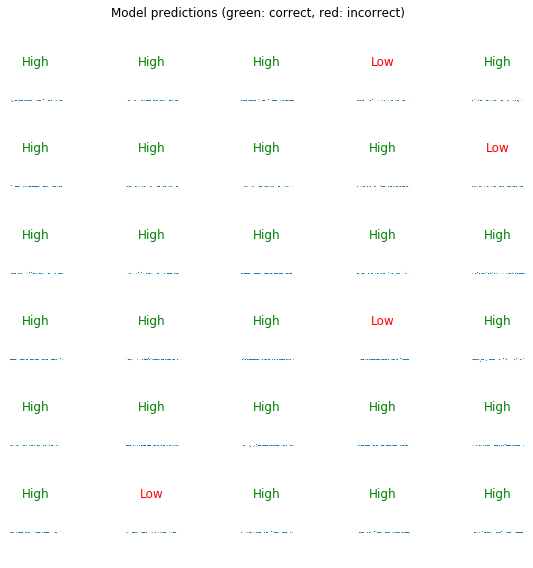

In [29]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [30]:
arr_pred = []
for n in range(test_generator.batch_size):
  arr_pred.append(1) if predicted_id[n] == label_id[n] else arr_pred.append(0)

print("Accuracy for this test batch: " +str(sum(arr_pred)/len(arr_pred)*100) + "%")

Accuracy for this test batch: 87.5%


## Export your model

Now that you've trained the model, export it as a saved model:

In [31]:
savepath = '/content/drive/My Drive/WristSense/CNNs_HAR_and_HR/Results/'
savefile = 'HAR_'+str(data_root)+'_model'
export_path = savepath+savefile
print(export_path)
model.save(export_path, save_format='tf')

/content/drive/My Drive/WristSense/CNNs_HAR_and_HR/Results/HAR_PPG_256Hz_model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /content/drive/My Drive/WristSense/CNNs_HAR_and_HR/Results/HAR_PPG_256Hz_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/WristSense/CNNs_HAR_and_HR/Results/HAR_PPG_256Hz_model/assets


## Test the model

In [0]:
probabilities = model.predict(test_generator)

In [0]:
y_true = test_generator.classes

### Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

p = probabilities > 0.25
y = []
for j in range(len(p)):
  y.append([i for i, x in enumerate(p[j]) if x])
y_pred = np.ones((len(y)))

for i in range(len(y)-1):
  y_pred[i] = y[i][0]

cmatrix = confusion_matrix(y_true, y_pred, normalize='true')

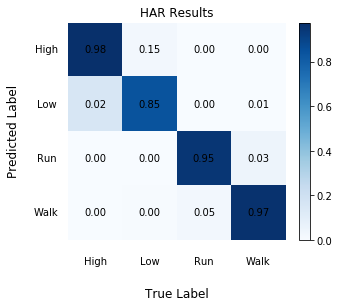

In [92]:
names = ['High', 'Low', 'Run', 'Walk']

plt.figure()
for i in range(4):
    for j in range(4):
        c = cmatrix[i,j]
        plt.text(i, j, ('%.2f'%c), va='center', ha='center')
        if j == 0:
          plt.text(i, j+3.9, (names[i]), va = 'center', ha = 'center')
        if i == 0:
          plt.text(i-0.9, j, (names[j]), va = 'center', ha = 'center')

plt.text(-1.5, 1.5, ('Predicted Label'), va = 'center', ha = 'center', rotation=90, fontsize = 12)
plt.text(1.5, 4.5, ('True Label'), va = 'center', ha = 'center', rotation=0, fontsize = 12)
plt.title('HAR Results')

plt.imshow(cmatrix, interpolation='nearest', cmap='Blues')
cbar = plt.colorbar(fraction= 0.046, pad=0.04)
cbar.set_label('', rotation=270, labelpad=30, fontsize=12)
plt.axis('off')

# Save Plot as svg file - need to edit some font colors further.
plt.savefig(export_path+'_Confusion_Matrix.svg', format='svg')

### F1-score

In [93]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred, average=None)

print("F1-Scores: ")
for i in range(len(names)):
  print(names[i], f1[i])

F1-Scores: 
High 0.8920863309352518
Low 0.9051987767584099
Run 0.9621993127147767
Walk 0.9622641509433963
